# Code Sandbox

A place to test new code and functions

In [ ]:
# import packages and set working directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
#os.chdir('../maize-Toff')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture

In [7]:
climate = Climate()

soil = Soil(texture='loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)

In [10]:
# IC
planting_date = 100
n_sim = 500
s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
output = model.run(s0=s0_mean, planting_date=planting_date, do_output=True)
output
t_start, t_end, lgp, dos_end = model.md()


In [4]:
planting_date = 10
n_sim = 500

# For loop of models 
# The two don't connect
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
output = [model.run(do_output=True, planting_date=planting_date) for model in models]
output

t_start, t_end, lgp, dos_end = model.md()

In [5]:
t_start

21

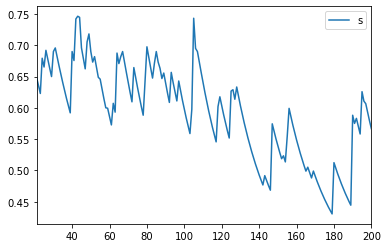

In [11]:
output

start = t_start
end = t_start + lgp

output.iloc[start:end].plot(y='s')


In [ ]:
average_soil_moisture(model, n_sims=1000, doy=90)

In [ ]:
n_sim = 1000
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

planting_date = 10

output = [model.run(do_output=True, planting_date=planting_date) for model in models]

s_avg = pd.DataFrame([o['s'].mean() for o in output])
s_avg.hist()

In [ ]:
output

In [ ]:
# Plot Time Series

def plot_ts(x, title, ylab):
    #d = np.arange(181)
    plt.plot(x, '-')
    plt.title(title)
    plt.xlabel('Time of Season, $\mathit{t}$')
    plt.ylabel(ylab)

# S and time
o = model.output()
plot_ts(o['s'], 'Relative soil moisture in model.output', 'Relative soil moisture, $\mathit{mm}$')